# Training a neural network on MNIST with Keras

This simple example demonstrates how to plug TensorFlow Datasets (TFDS) into a Keras model.


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/datasets/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [21]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt

from keras.datasets import mnist

from IPython.display import clear_output


## Step 1: Create your input pipeline

Start by building an efficient input pipeline using advices from:
* The [Performance tips](https://www.tensorflow.org/datasets/performances) guide
* The [Better performance with the `tf.data` API](https://www.tensorflow.org/guide/data_performance#optimize_performance) guide


### Load a dataset

Load the MNIST dataset with the following arguments:

* `shuffle_files=True`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [2]:
# Two ways to load the dataset
# First, using the Tensor FLow datasets
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# And also the mnist dataset from Keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[..., tf.newaxis]  # Add channel dimension
x_test = x_test[..., tf.newaxis]  # Add channel dimension

ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))


### Build a training pipeline

Apply the following transformations:

* `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32`. Therefore, you need to normalize images.
* `tf.data.Dataset.cache` As you fit the dataset in memory, cache it before shuffling for a better performance.<br/>
__Note:__ Random transformations should be applied after caching.
* `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For large datasets that can't fit in memory, use `buffer_size=1000` if your system allows it.
* `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch.
* `tf.data.Dataset.prefetch`: It is good practice to end the pipeline by prefetching [for performance](https://www.tensorflow.org/guide/data_performance#prefetching).

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label


def make_pipeline(ds, ds_info, shuffle = True):

    ds = ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(ds_info.splits['train'].num_examples)
    ds = ds.batch(128)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

ds_train = make_pipeline(ds_train, ds_info)


### Build an evaluation pipeline

Your testing pipeline is similar to the training pipeline with small differences:

 * You don't need to call `tf.data.Dataset.shuffle`.
 * Caching is done after batching because batches can be the same between epochs.

In [4]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Step 2: Create and train the model

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

In [32]:
class SimpleLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        print(f'Epoch {epoch + 1}/{self.params["epochs"]}')
        if logs is not None:
            try:
                print(f'loss: {logs["loss"]:.4f} - accuracy: {logs["sparse_categorical_accuracy"]:.4f} - val_loss: {logs["val_loss"]:.4f} - val_accuracy: {logs["val_sparse_categorical_accuracy"]:.4f}')
            except Exception as e:
                print(e)


def model1(input_shape, output_class):
    
    m = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(output_class)
    ])

    m.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    return m

def model2(input_shape, output_class):

    import tensorflow as tf

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
     
    model = Sequential()
    model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dropout(0.3))
    model.add(Dense(output_class, activation=tf.nn.softmax))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

input_shape=(28, 28, 1)
output_class = 10

model1 = model1(input_shape, output_class)
model2 = model2(input_shape, output_class)

def train_model(model, ds_train, ds_test, epochs = 6):

    history = model.fit(
        ds_train,
        epochs=6,
        validation_data=ds_test,
        callbacks=[SimpleLogger()]
    )

    return history

200/469 [===========>..................] - ETA: 0s - loss: 0.1710 - sparse_categorical_accuracy: 0.9512

222/469 [=============>................] - ETA: 0s - loss: 0.1716 - sparse_categorical_accuracy: 0.9512

244/469 [==============>...............] - ETA: 0s - loss: 0.1695 - sparse_categorical_accuracy: 0.9521

266/469 [================>.............] - ETA: 0s - loss: 0.1676 - sparse_categorical_accuracy: 0.9525

288/469 [=================>............] - ETA: 0s - loss: 0.1670 - sparse_categorical_accuracy: 0.9526

310/469 [==================>...........] - ETA: 0s - loss: 0.1657 - sparse_categorical_accuracy: 0.9528

333/469 [====================>.........] - ETA: 0s - loss: 0.1653 - sparse_categorical_accuracy: 0.9528

355/469 [=====================>........] - ETA: 0s - loss: 0.1644 - sparse_categorical_accuracy: 0.9529

377/469 [=======================>......] - ETA: 0s - loss: 0.1643 - sparse_categorical_accuracy: 0.9530

400/469 [========================>.....] - ETA: 0s - loss: 0.1633 - sparse_categorical_accuracy: 0.9532

423/469 [==========================>...] - ETA: 0s - loss: 0.1616 - sparse_categorical_accuracy: 0.9538

446/469 [===========================>..] - ETA: 0s - loss: 0.1606 - sparse_categorical_accuracy: 0.9542

469/469 [==============================] - ETA: 0s - loss: 0.1602 - sparse_categorical_accuracy: 0.9543

469/469 [==============================] - 1s 3ms/step - loss: 0.1602 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.1392 - val_sparse_categorical_accuracy: 0.9588


Epoch 3/6


  1/469 [..............................] - ETA: 32s - loss: 0.1546 - sparse_categorical_accuracy: 0.9609

 23/469 [>.............................] - ETA: 1s - loss: 0.1243 - sparse_categorical_accuracy: 0.9640 

 45/469 [=>............................] - ETA: 0s - loss: 0.1216 - sparse_categorical_accuracy: 0.9648

 67/469 [===>..........................] - ETA: 0s - loss: 0.1272 - sparse_categorical_accuracy: 0.9628

 90/469 [====>.........................] - ETA: 0s - loss: 0.1230 - sparse_categorical_accuracy: 0.9653

113/469 [======>.......................] - ETA: 0s - loss: 0.1236 - sparse_categorical_accuracy: 0.9649

136/469 [=======>......................] - ETA: 0s - loss: 0.1238 - sparse_categorical_accuracy: 0.9649

159/469 [=========>....................] - ETA: 0s - loss: 0.1227 - sparse_categorical_accuracy: 0.9651

182/469 [==========>...................] - ETA: 0s - loss: 0.1205 - sparse_categorical_accuracy: 0.9658

205/469 [============>.................] - ETA: 0s - loss: 0.1186 - sparse_categorical_accuracy: 0.9664

227/469 [=============>................] - ETA: 0s - loss: 0.1192 - sparse_categorical_accuracy: 0.9661

249/469 [==============>...............] - ETA: 0s - loss: 0.1189 - sparse_categorical_accuracy: 0.9661

271/469 [================>.............] - ETA: 0s - loss: 0.1182 - sparse_categorical_accuracy: 0.9662

293/469 [=================>............] - ETA: 0s - loss: 0.1178 - sparse_categorical_accuracy: 0.9666

316/469 [===================>..........] - ETA: 0s - loss: 0.1185 - sparse_categorical_accuracy: 0.9662

338/469 [====================>.........] - ETA: 0s - loss: 0.1186 - sparse_categorical_accuracy: 0.9662

361/469 [======================>.......] - ETA: 0s - loss: 0.1185 - sparse_categorical_accuracy: 0.9660

384/469 [=======================>......] - ETA: 0s - loss: 0.1177 - sparse_categorical_accuracy: 0.9661

407/469 [=========================>....] - ETA: 0s - loss: 0.1178 - sparse_categorical_accuracy: 0.9663

430/469 [==========================>...] - ETA: 0s - loss: 0.1177 - sparse_categorical_accuracy: 0.9662

453/469 [===========================>..] - ETA: 0s - loss: 0.1173 - sparse_categorical_accuracy: 0.9664

469/469 [==============================] - 1s 2ms/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9664 - val_loss: 0.1084 - val_sparse_categorical_accuracy: 0.9693


Epoch 4/6


  1/469 [..............................] - ETA: 32s - loss: 0.0986 - sparse_categorical_accuracy: 0.9688

 24/469 [>.............................] - ETA: 0s - loss: 0.1070 - sparse_categorical_accuracy: 0.9684 

 47/469 [==>...........................] - ETA: 0s - loss: 0.1030 - sparse_categorical_accuracy: 0.9714

 70/469 [===>..........................] - ETA: 0s - loss: 0.0953 - sparse_categorical_accuracy: 0.9733

 93/469 [====>.........................] - ETA: 0s - loss: 0.0948 - sparse_categorical_accuracy: 0.9733

116/469 [======>.......................] - ETA: 0s - loss: 0.0920 - sparse_categorical_accuracy: 0.9744

139/469 [=======>......................] - ETA: 0s - loss: 0.0917 - sparse_categorical_accuracy: 0.9747

161/469 [=========>....................] - ETA: 0s - loss: 0.0920 - sparse_categorical_accuracy: 0.9746

184/469 [==========>...................] - ETA: 0s - loss: 0.0915 - sparse_categorical_accuracy: 0.9748

206/469 [============>.................] - ETA: 0s - loss: 0.0912 - sparse_categorical_accuracy: 0.9745

228/469 [=============>................] - ETA: 0s - loss: 0.0913 - sparse_categorical_accuracy: 0.9746

251/469 [===============>..............] - ETA: 0s - loss: 0.0923 - sparse_categorical_accuracy: 0.9744

273/469 [================>.............] - ETA: 0s - loss: 0.0920 - sparse_categorical_accuracy: 0.9746

295/469 [=================>............] - ETA: 0s - loss: 0.0923 - sparse_categorical_accuracy: 0.9742

317/469 [===================>..........] - ETA: 0s - loss: 0.0929 - sparse_categorical_accuracy: 0.9740

339/469 [====================>.........] - ETA: 0s - loss: 0.0931 - sparse_categorical_accuracy: 0.9738

361/469 [======================>.......] - ETA: 0s - loss: 0.0924 - sparse_categorical_accuracy: 0.9740

383/469 [=======================>......] - ETA: 0s - loss: 0.0923 - sparse_categorical_accuracy: 0.9741

405/469 [========================>.....] - ETA: 0s - loss: 0.0921 - sparse_categorical_accuracy: 0.9741

428/469 [==========================>...] - ETA: 0s - loss: 0.0917 - sparse_categorical_accuracy: 0.9742

451/469 [===========================>..] - ETA: 0s - loss: 0.0913 - sparse_categorical_accuracy: 0.9743

469/469 [==============================] - 1s 3ms/step - loss: 0.0911 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.0968 - val_sparse_categorical_accuracy: 0.9714


Epoch 5/6


  1/469 [..............................] - ETA: 32s - loss: 0.0625 - sparse_categorical_accuracy: 0.9922

 23/469 [>.............................] - ETA: 1s - loss: 0.0698 - sparse_categorical_accuracy: 0.9820 

 45/469 [=>............................] - ETA: 0s - loss: 0.0682 - sparse_categorical_accuracy: 0.9811

 68/469 [===>..........................] - ETA: 0s - loss: 0.0707 - sparse_categorical_accuracy: 0.9805

 90/469 [====>.........................] - ETA: 0s - loss: 0.0729 - sparse_categorical_accuracy: 0.9793

112/469 [======>.......................] - ETA: 0s - loss: 0.0734 - sparse_categorical_accuracy: 0.9794

135/469 [=======>......................] - ETA: 0s - loss: 0.0752 - sparse_categorical_accuracy: 0.9791

158/469 [=========>....................] - ETA: 0s - loss: 0.0742 - sparse_categorical_accuracy: 0.9794

181/469 [==========>...................] - ETA: 0s - loss: 0.0738 - sparse_categorical_accuracy: 0.9795

204/469 [============>.................] - ETA: 0s - loss: 0.0728 - sparse_categorical_accuracy: 0.9797

227/469 [=============>................] - ETA: 0s - loss: 0.0727 - sparse_categorical_accuracy: 0.9797

249/469 [==============>...............] - ETA: 0s - loss: 0.0715 - sparse_categorical_accuracy: 0.9802

271/469 [================>.............] - ETA: 0s - loss: 0.0704 - sparse_categorical_accuracy: 0.9806

293/469 [=================>............] - ETA: 0s - loss: 0.0705 - sparse_categorical_accuracy: 0.9805

315/469 [===================>..........] - ETA: 0s - loss: 0.0709 - sparse_categorical_accuracy: 0.9804

337/469 [====================>.........] - ETA: 0s - loss: 0.0708 - sparse_categorical_accuracy: 0.9802

360/469 [======================>.......] - ETA: 0s - loss: 0.0720 - sparse_categorical_accuracy: 0.9797

383/469 [=======================>......] - ETA: 0s - loss: 0.0729 - sparse_categorical_accuracy: 0.9791

406/469 [========================>.....] - ETA: 0s - loss: 0.0727 - sparse_categorical_accuracy: 0.9792

429/469 [==========================>...] - ETA: 0s - loss: 0.0731 - sparse_categorical_accuracy: 0.9791

452/469 [===========================>..] - ETA: 0s - loss: 0.0735 - sparse_categorical_accuracy: 0.9791

469/469 [==============================] - 1s 2ms/step - loss: 0.0738 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.0881 - val_sparse_categorical_accuracy: 0.9735


Epoch 6/6


  1/469 [..............................] - ETA: 32s - loss: 0.0219 - sparse_categorical_accuracy: 1.0000

 24/469 [>.............................] - ETA: 1s - loss: 0.0620 - sparse_categorical_accuracy: 0.9821 

 47/469 [==>...........................] - ETA: 0s - loss: 0.0629 - sparse_categorical_accuracy: 0.9830

 70/469 [===>..........................] - ETA: 0s - loss: 0.0640 - sparse_categorical_accuracy: 0.9830

 93/469 [====>.........................] - ETA: 0s - loss: 0.0619 - sparse_categorical_accuracy: 0.9830

116/469 [======>.......................] - ETA: 0s - loss: 0.0614 - sparse_categorical_accuracy: 0.9829

139/469 [=======>......................] - ETA: 0s - loss: 0.0620 - sparse_categorical_accuracy: 0.9823

162/469 [=========>....................] - ETA: 0s - loss: 0.0632 - sparse_categorical_accuracy: 0.9820

185/469 [==========>...................] - ETA: 0s - loss: 0.0630 - sparse_categorical_accuracy: 0.9821

208/469 [============>.................] - ETA: 0s - loss: 0.0624 - sparse_categorical_accuracy: 0.9823

231/469 [=============>................] - ETA: 0s - loss: 0.0634 - sparse_categorical_accuracy: 0.9821

254/469 [===============>..............] - ETA: 0s - loss: 0.0630 - sparse_categorical_accuracy: 0.9822

277/469 [================>.............] - ETA: 0s - loss: 0.0634 - sparse_categorical_accuracy: 0.9819

300/469 [==================>...........] - ETA: 0s - loss: 0.0633 - sparse_categorical_accuracy: 0.9821

322/469 [===================>..........] - ETA: 0s - loss: 0.0633 - sparse_categorical_accuracy: 0.9821

345/469 [=====================>........] - ETA: 0s - loss: 0.0627 - sparse_categorical_accuracy: 0.9821

368/469 [======================>.......] - ETA: 0s - loss: 0.0628 - sparse_categorical_accuracy: 0.9820

390/469 [=======================>......] - ETA: 0s - loss: 0.0625 - sparse_categorical_accuracy: 0.9822

413/469 [=========================>....] - ETA: 0s - loss: 0.0622 - sparse_categorical_accuracy: 0.9823

435/469 [==========================>...] - ETA: 0s - loss: 0.0618 - sparse_categorical_accuracy: 0.9823

457/469 [============================>.] - ETA: 0s - loss: 0.0618 - sparse_categorical_accuracy: 0.9823

469/469 [==============================] - 1s 2ms/step - loss: 0.0617 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.0793 - val_sparse_categorical_accuracy: 0.9749


Epoch 6/6
loss: 0.0614 - accuracy: 0.9824 - val_loss: 0.0835 - val_accuracy: 0.9753
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0594 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.0835 - val_sparse_categorical_accuracy: 0.9753


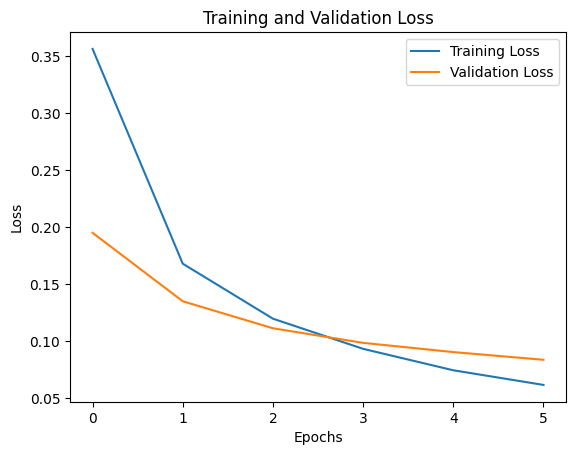

In [33]:
history = train_model(model1, ds_train, ds_test)

# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 6/6
'sparse_categorical_accuracy'
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9862 - loss: 0.0430 - val_accuracy: 0.9842 - val_loss: 0.0516


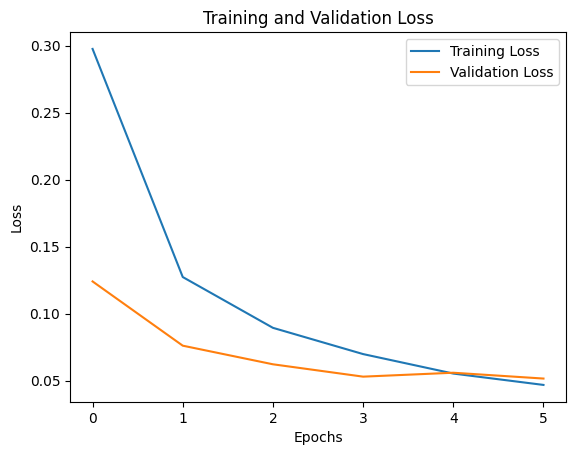

In [34]:
history = train_model(model2, ds_train, ds_test)

# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


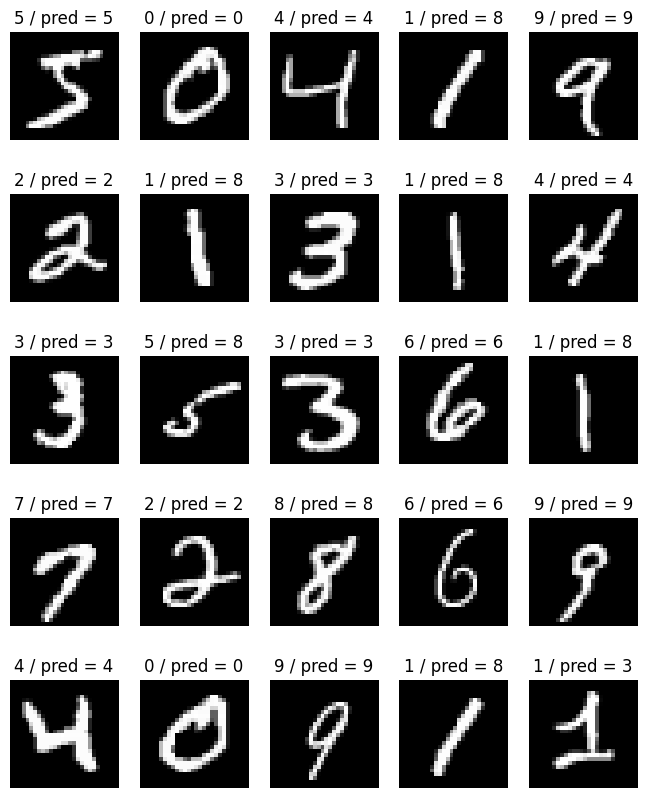

In [11]:
images_and_labels = list(zip(x_train, y_train))

plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.6, hspace=.35)
for i, (image, label) in enumerate(images_and_labels[:25]):
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray, interpolation='nearest')

    pred_args = model.predict(image.reshape(1,28,28,1))
    pred = pred_args.argmax()
    
    plt.title(f'{label} / pred = {pred}')

In [13]:
pred_args

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)